In [2]:
import numpy as np
import optimisation as opt
import moments_std as est
import importlib
import noise as nois
import utils as utl
importlib.reload(opt)
importlib.reload(est)
importlib.reload(nois)
importlib.reload(utl)

<module 'utils' from '/Users/krzywdaja/Documents/Science/Science/Projects/cluster/utils.py'>

## Open AI gym


In [3]:
from stable_baselines3 import PPO
%load_ext tensorboard

In [4]:

import numpy as np
# Load the TensorBoard notebook extension
%load_ext tensorboard
import matplotlib.pyplot as plt
from stable_baselines3.common.evaluation import evaluate_policy




class data():
    def __init__(self, res, penalty):
        self.penalty = penalty
        self.actions = res.actions.flatten()
        self.rewards = res.rewards.flatten()
        self.mus = res.mus.flatten()
        self.oms = res.oms.flatten()
        self.stds = res.stds.flatten()*self.mus
        self.errors = self.mus-self.oms
        self.est_prob = np.sum(self.rewards==0)/len(self.rewards)
        self.succ_prob = np.sum(self.rewards==1)/len(self.rewards)
        self.fidelity = np.sum(self.rewards==1)/(np.sum(self.rewards<0)+np.sum(self.rewards==1))
        self.infidelity = np.sum(self.rewards<0)/(np.sum(self.rewards<0)+np.sum(self.rewards==1))

    def return_row(self):
        row = []
        row.append(self.penalty)
        row.append(np.mean(np.abs(self.errors)))
        row.append(self.est_prob)
        row.append(self.succ_prob)
        row.append(self.fidelity)
        return np.array(row)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [25]:
noiseou = nois.OU_noise(sigma=2, gamma=1/1e3)

In [24]:
#noise = nois.OU_noise(sigma = 10, tc = 1000)

om0 = 10
env = est.Moments_estimation(length = 1000, 
                                  om0 = om0, 
                                  noise = noiseou,
                                  max_time = 1000,
                                  penalty = -1,
                                  time_step = 1,
                                  min_time = 1,
                                  buffer_size=1)


def policy_flip(state, **kwargs):
    return 0

def policy_random_p(n,state, *args, **kwargs):
    pflip = kwargs["x"][0]
    t_max = kwargs["x"][1]
    r = np.random.choice([0,1], p=[pflip,1-pflip])

    if r == 0:
        return 0
    else:
        return np.random.randint(1,t_max)
    

def policy_random_p_overc(n, state, *args, **kwargs):
    pflip = kwargs["x"][0]
    t_max = kwargs["x"][1]
    r = np.random.choice([0,1], p=[pflip,1-pflip])

    if r == 0:
        return 0
    else:
        #print(state[1])
        #print(state[0])
        #print(1/state[1]/state[0]/10)
        return int(1/state[1]/state[0]*1e3/10)

x = [[0.98,20],[0.98,50],[0.98,100],[0.98,150],[0.98,200]]
results2 = []
for k in range(1):
    res = opt.game(100, env, policy=policy_random_p_overc, x = x[k])
    results2.append(data(res,0))

TypeError: 'int' object is not subscriptable

In [6]:
y2 = []
for k in range(5):
    y2.append(results2[k].infidelity)

plt.hline(y2)
plt.plot(y)
plt.yscale("log")

NameError: name 'results2' is not defined

In [7]:
for k in range(1):

        plt.plot(res.mus[k])
        plt.plot(res.oms[k])

        plt.plot(res.stds[k]*res.mus[k])
#plt.plot(np.abs(res.mus[0] - np.abs(res.oms[0])))

NameError: name 'res' is not defined

In [7]:
import gymnasium as gym
import os
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import EvalCallback
#import monitor
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

In [32]:


# Save a checkpoint every 1000 steps
'''
checkpoint_callback = CheckpointCallback(
  save_freq=10000,
  save_path="./logs/",
  name_prefix="flex_",
  save_replay_buffer=True,
  save_vecnormalize=True,
)
'''

# Parallel environments
logdir ="./ppo_bayes_tensorboard/"
om0 = 10
penalty = [-5]  #-1,-10,-100 are ok
length = 1000
for p in penalty:
    env = est.Moments_estimation(length = length, 
                                  om0 = om0, 
                                  noise = noiseou,
                                  max_time = 100,
                                  penalty = p,
                                  time_step = 5,
                                  min_time = 1,
                                  buffer_size = 5,
                                  std_step = 0.0001
                                  )
    env = Monitor(env, logdir)
    eval_callback = EvalCallback(env, best_model_save_path="./logs2/t2"+str(p)+"/",
                                log_path="./logs2/"+str(p)+"/t2", eval_freq=100000,
                                deterministic=False, render=False, n_eval_episodes=16) #?

    if not os.path.exists("./ppo_bayes_tensorboard/"):
        os.makedirs("./ppo_bayes_tensorboard/")

    #model = model.load("logs/best_model.zip")
    model = PPO("MlpPolicy", env, 
                n_steps = 8*length,  # what is that!
                batch_size=100,
                ent_coef=0.01,
                verbose=1, tensorboard_log="./ppo_bayes_tensorboard/", gamma = 1)

    model.learn(total_timesteps=500000, tb_log_name="PPO",callback=eval_callback )


    


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to ./ppo_bayes_tensorboard/PPO_9
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 47.9     |
| time/              |          |
|    fps             | 1713     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 8000     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 63.4        |
| time/                   |             |
|    fps                  | 1244        |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 16000       |
| train/                  |             |
|    approx_kl            | 0.011758085 |
|    clip_fraction        | 0.0971      |
|    clip_range           | 0.2         |
|    entropy_loss    

In [10]:
import tensorboard as tb

In [9]:
%tensorboard --logdir ppo_bayes_tensorboard --port 4564

Reusing TensorBoard on port 4564 (pid 30089), started 0:00:01 ago. (Use '!kill 30089' to kill it.)

# Plot the reward for N=100

In [20]:
#get all files from folder
import os

path = "./logs2/t2-10/"
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.zip' in file:
            files.append(os.path.join(r, file))
print(files)

['./logs2/t2-10/best_model.zip']


-5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

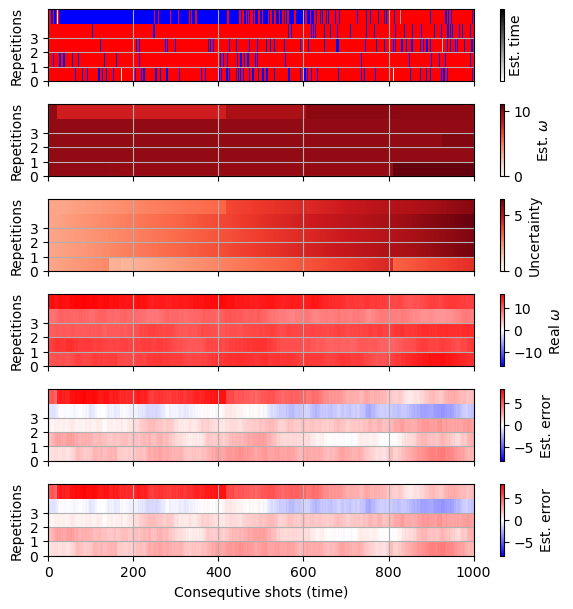

<Figure size 640x480 with 0 Axes>

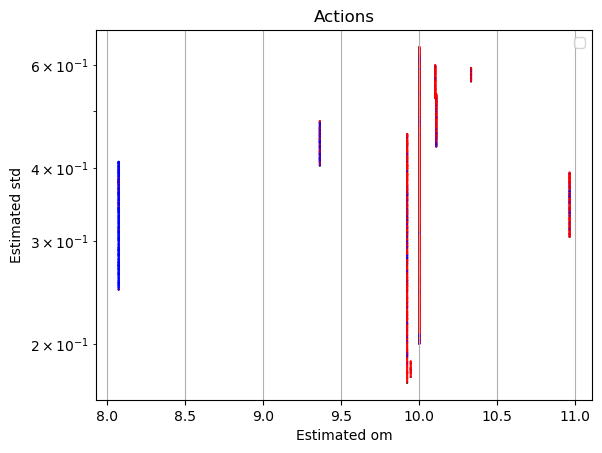

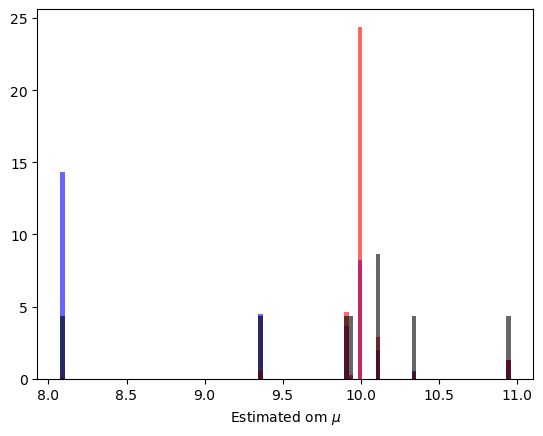

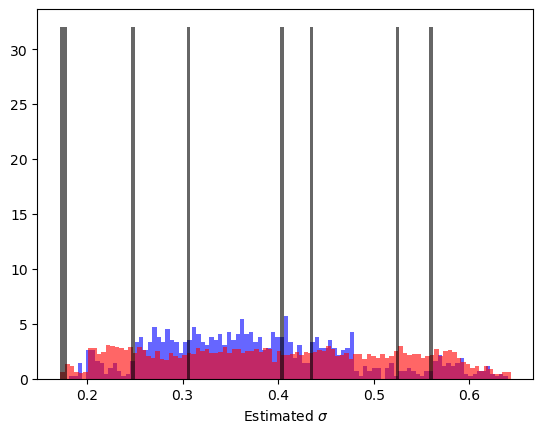

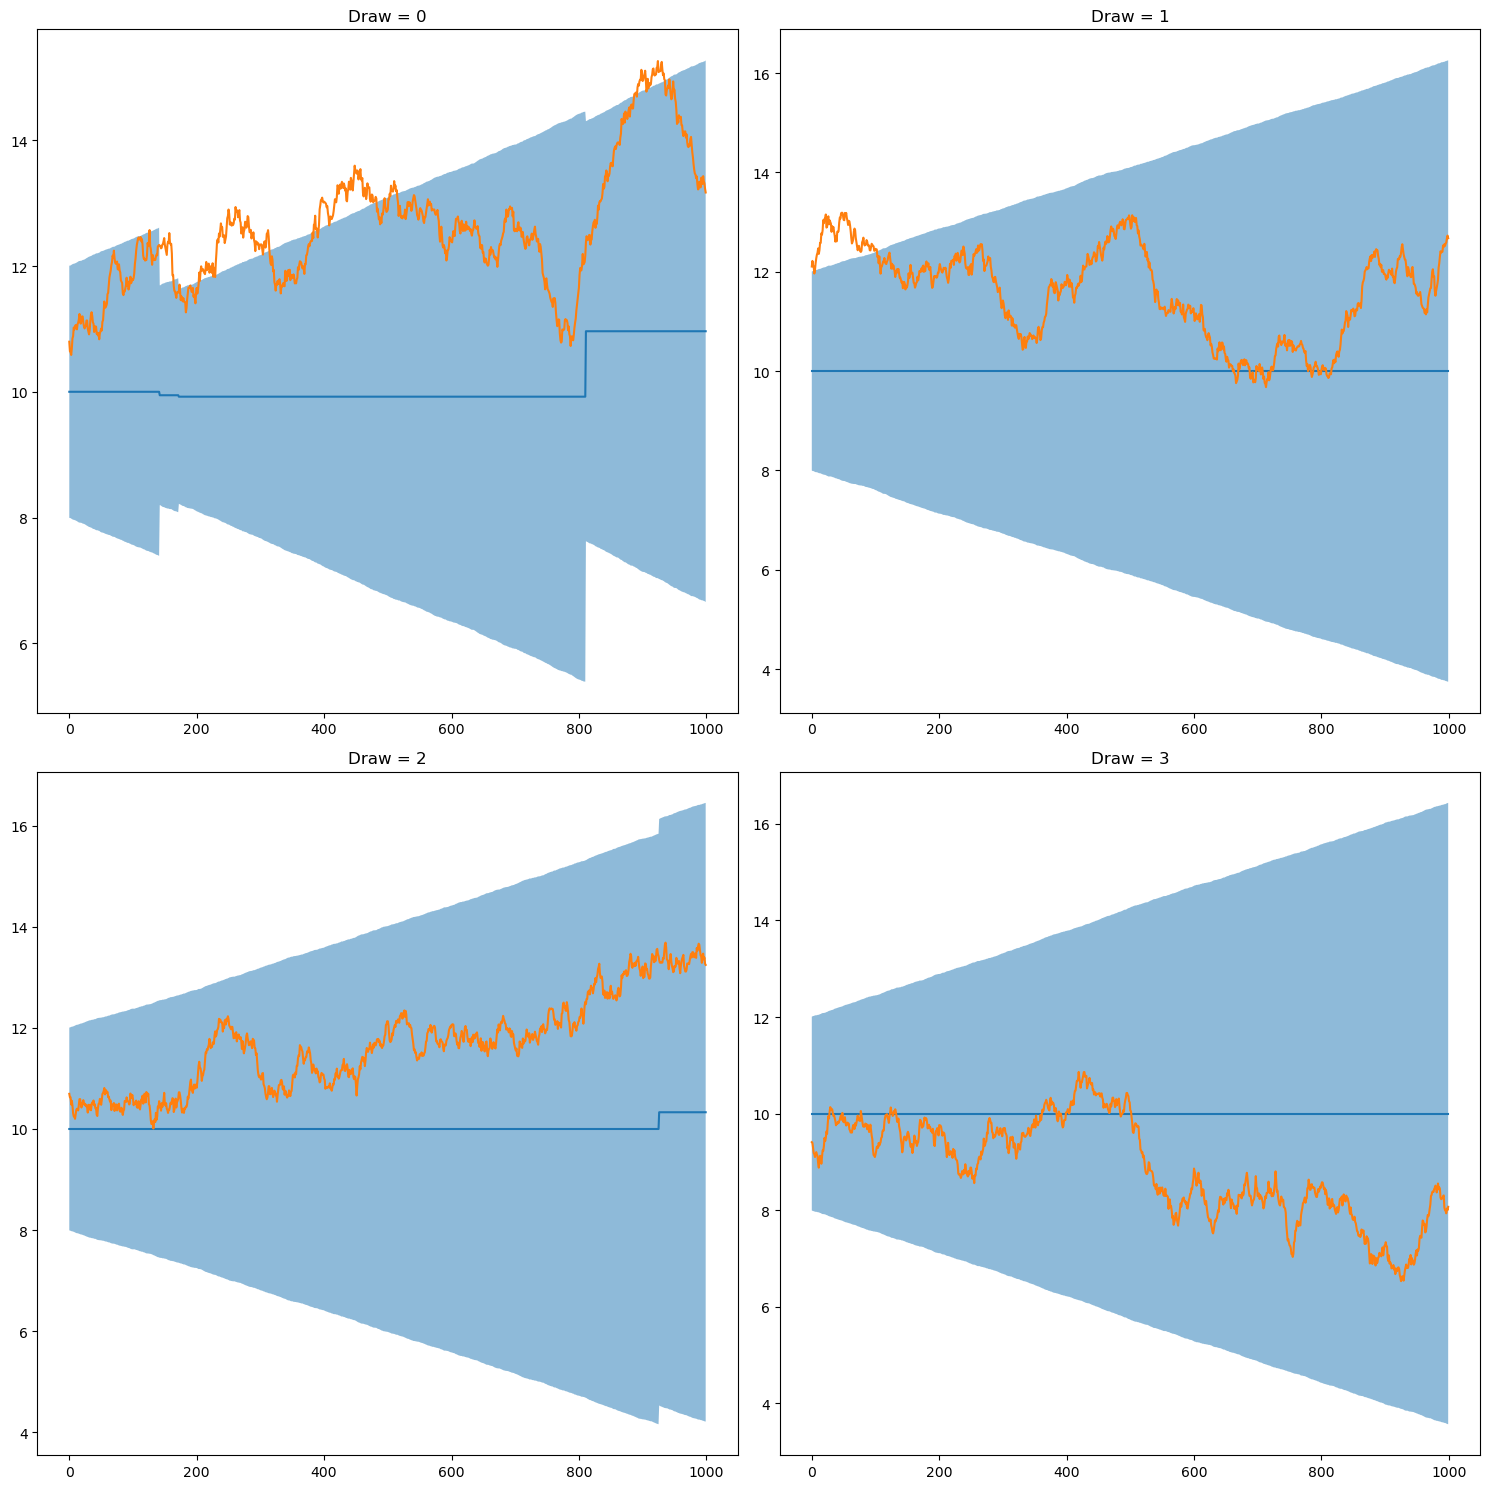

In [31]:
importlib.reload(opt)
importlib.reload(utl)

om0 = 10
#penalty = [-0.1,-1,-5,-25]  #with ts = 1, max_time = 50
penalty = [-5]  # with ts = 5, max_time = 81
results = []
N = 5
for p in penalty:
    env = est.Moments_estimation(length = length, 
                                  om0 = om0, 
                                  noise = noiseou,
                                  max_time = 100,
                                  penalty = p,
                                  time_step = 5,
                                  min_time = 1,
                                  buffer_size = 5,
                                  std_step = 0.0001
                                  )
                                  
    #model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./ppo_bayes_tensorboard/", gamma = 1)
    model = model.load('./logs2/t2-5/best_model.zip')
   
    res2 =  opt.game(N, env, model)
    print(p)
    plt.figure()
    utl.analyse_few_games4(res2, "1f")
    #results.append(np.average(res2.rewards.sum(axis=1)))
    plt.figure()
    results.append(res2)
    #utl.analyse_time(res2, "1f")
    plt.figure()
    utl.analyse_decisions(res2, str(1e3))
    #create 4x4 subplots
    fig, axs = plt.subplots(int(np.sqrt(N)), int(np.sqrt(N)), figsize=(15, 15))
    #draw 16 integers from 0 to 50
    for i, ax in enumerate(axs.flat):
        ax.plot(res2.mus[i])
        ax.plot(np.abs(res2.oms[i]))
        ax.fill_between(np.arange(length), res2.mus[i] - res2.stds[i]*res2.mus[i], res2.mus[i] + res2.stds[i]*res2.mus[i], alpha=0.5)
        ax.set_title(f"Draw = {i}")
        #ax.set_ylim(0,50)
plt.tight_layout()



#res1 = evaluate_policy(model, env, n_eval_episodes=N, deterministic=False, return_episode_rewards=True)



In [31]:
class data():
    def __init__(self, res, penalty):
        self.penalty = penalty
        self.actions = 
        self.mus = 
        self.oms = 
        self.stds = 
        self.errors = 
        self.est_prob = 
        self.succ_prob = 
        self.fidelity =

    def return_row(self):
        row = []
        row.append(np.mean(np.abs(self.errors)))
        row.append(self.penalty)
        row.append(self.est_prob)
        row.append(self.succ_prob)
        row.append(self.fidelity)

[8880.568, 8510.6, 6908.18, 4695.94]


In [ ]:
#create 4x4 subplots
fig, axs = plt.subplots(int(np.sqrt(N)), int(np.sqrt(N)), figsize=(15, 15))
#draw 16 integers from 0 to 50
draws = np.random.randint(0,N,100)
for i, ax in enumerate(axs.flat):
    ax.plot(res2.mus[i])
    ax.plot(np.abs(res2.oms[i]))
    ax.fill_between(np.arange(100), res2.mus[i] - res2.stds[i]*res2.mus[i], res2.mus[i] + res2.stds[i]*res2.mus[i], alpha=0.5)
    ax.set_title(f"Draw = {draws[i]}")
    #ax.set_ylim(0,50)
    ax.set_xlim(0,100)
plt.tight_layout()

In [ ]:
import utils as utl
importlib.reload(utl)
import numpy as np
import optimisation as opt
import moments_backend as est
import importlib
import noise as nois
importlib.reload(opt)
importlib.reload(est)
importlib.reload(nois)
utl.analyse_few_games4(res2, "1/f")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 640x480 with 0 Axes>

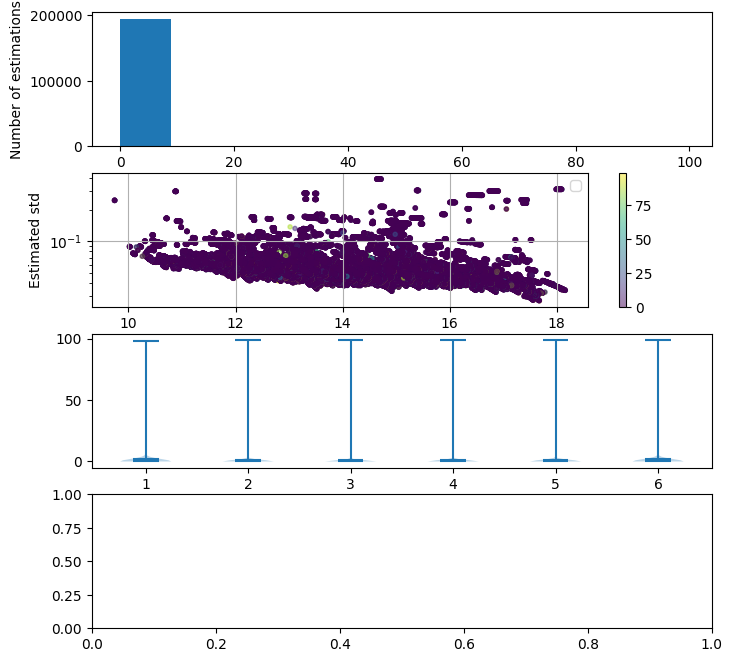

In [16]:
utl.analyse_time(res2, "1/f")

In [ ]:
utl.analyse_decisions(res2, str(1e3))

In [ ]:
plt.plot(res2.mus[8])
plt.plot(np.abs(res2.oms[8]))

In [ ]:
plt.figure(figsize= (3,2))
x = res2.mus[res2.actions[0]==1].flatten()
y = res2.stds[res2.actions[0]==1].flatten()
c = res2.actions[1][res2.actions[0]==1].flatten()


plt.scatter(x,y/x,c=c, alpha=0.5, marker=".", cmap="Grays", vmax = 2*np.max(c))

plt.xlabel("Estiamted field $\mu$")
plt.ylabel("Uncertainty $\sigma/\mu$")
c = plt.colorbar()
c.set_label("Estimation time")
x = res2.mus[res2.actions[0]==0].flatten()
y = res2.stds[res2.actions[0]==0].flatten()
c = res2.rewards[res2.actions[0]==0].flatten()

plt.scatter(x,y/x,c=c, alpha=0.5, marker=".", cmap="bwr")
#get rid of the frame of the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().get_xaxis().tick_bottom()
plt.gca().get_yaxis().tick_left()



In [ ]:


tcs = [1e3]
for tc in tcs:


    samples = 6
    model = model.load("flex")


    results = opt.game(episodes = samples, model=model, env=env)
    
    est.analyse_few_games(results, str(tc))



In [ ]:
for tc in tcs:


    samples = 20
    model.load("ppo_N1e3_check_"+str(tc))
    env = est.EstimationEnv(length = int(1e3), tc = tc, om0=om0, sigma = sigma, initial_std=initial_std, 
                        seed_shot= seed_environment, seed_field = seed_environment)

    results = opt.game(episodes = samples, model=model, env=env)

    est.analyse_decisions(results, str(tc))



In [ ]:
env.tc

In [ ]:

policies = opt.policy_random_p, opt.policy_max_std, opt.policy_min_mu, opt.policy_interval
bounds = [np.array([[0,1],[0,1],[0,1]]),
            np.array([[0,10],[0,1]]),
            np.array([[0,100],[0,1]]),
            np.array([[0,100],[0,100],[0,100]])]
sigmas = [np.array(0.5), np.array(50.), np.array(50.), np.array(50.)]
means = [np.array([0.7,0.2,0.1]), np.array([5.,0.5]), np.array([50.,0.2]), np.array([50.,10.,2.])]


xs = []
for tc in [1e3]:
    xs_tc = []
    for pn,policy in enumerate(policies):
        if pn==0:
            print(bounds[pn])
            print(sigmas[pn])
            print(means[pn])
            env = est.EstimationEnv(length = 1000, tc = 1e3, om0=om0, sigma = sigma, initial_std=initial_std,
                            seed_field = None, seed_shot = None)
            Opt = opt.CMA_optimizer(policy = policies[pn], 
                            generations = 20, 
                            population_size=10, 
                            bounds = bounds[pn], 
                            sigma = sigmas[pn], 
                            mean= means[pn], 
                            episodes = 20,
                            env=env)
            sol = Opt.optimize()
            x_avg, f_avg = Opt.get_representative()
            xs_tc.append(x_avg)
    xs.append(xs_tc)
    

In [ ]:
xs_tc

In [ ]:
#save nested xs list to file
import pickle
with open('xs2.pkl', 'wb') as f:
    pickle.dump(xs, f)


In [ ]:
#load nested xs list from file
import pickle
with open('xs.pkl', 'rb') as f:
    xs = pickle.load(f)


In [ ]:
xs

In [ ]:
sol[:,:,:3] = sol[:,:,:3]/np.sum(sol[:,:,:3],axis=2)[...,None]
for k in range(4):
    plt.scatter(sol[k,:,0], sol[k,:,1], label = str(k))
plt.legend()

In [ ]:
import numpy as np
import optimisation as opt
import estimation_environment as est
import importlib
importlib.reload(opt)
importlib.reload(est)
policies = 7
'''
-always flip
-random
-random with flip p =0.8, est p = 0.15, check p = 0,5
-flip only if std/mu below 0.5
-flip only if mu is above 10
-estimate 5 shots every 30 shots
-agent
'''





#model = model.load("ppo_bayes2")

samples = 50

policies_all = opt.policy_flip, opt.policy_random, opt.policy_random_p, opt.policy_max_std, opt.policy_min_mu, opt.policy_interval

tot_reward = np.zeros((len(tcs),len(policies_all)+1,samples))

for tcn, tc in enumerate(tcs):
    model.load("ppo_N500_"+str(tc))
    
    for pn,policy in enumerate(policies_all):
        
        env = est.EstimationEnv(length = 500, tc = tc, om0=om0, sigma = sigma, initial_std=initial_std, 
                    seed_shot= seed_environment, seed_field = seed_environment)
        if pn>1:
            results = opt.game(episodes = samples, policy=policies_all[pn], env=env, x = xs[tcn][pn-2], rng_est = np.random.default_rng(seed_estimation))
            tot_reward[tcn,pn,:] = np.sum(results.rewards,axis=1)
        else:
            results = opt.game(episodes = samples, policy=policies_all[pn], env=env, rng_est = np.random.default_rng(seed_estimation))
            tot_reward[tcn,pn,:] = np.sum(results.rewards,axis=1)
    
    env = est.EstimationEnv(length = 500, tc = tc, om0=om0, sigma = sigma, initial_std=initial_std, 
                    seed_shot= seed_environment, seed_field = seed_environment)
    results = opt.game(episodes = samples, model=model, env=env)
    tot_reward[tcn,-1,:] =  np.sum(results.rewards,axis=1)

In [ ]:
tcs

In [ ]:
#compare rewards using different policies via violin plot
plt.figure(figsize=(13,5))
for tcn,tc in enumerate(tcs):
    plt.violinplot(tot_reward[tcn].T, showmeans=True, positions=np.arange(1,8)-.2+tcn*0.2, widths=0.5)
plt.xticks(np.arange(1,8),["Always flip","Random","Random with prob",r"Flip if $\sigma/\mu<\sigma_\text{max}$",r"Flip if $\mu>\mu_\text{min}$",
                            "Estimation intervals","Agent"])
plt.ylabel("Total reward")
#plt.ylim(-200,550)
plt.grid()
plt.plot([],[],color = "blue", label="tc = 100")
plt.plot([],[],color = "orange", label="tc = 200")
plt.plot([],[],color = "green", label="tc = 300")
plt.legend(loc="lower right")


In [ ]:
#compare rewards using different policies via violin plot
plt.figure(figsize=(13,5))
for tcn,tc in enumerate(tcs):
    plt.figure(figsize=(13,5))
    plt.violinplot(tot_reward[tcn].T, showmeans=True, positions=np.arange(1,8), widths=0.5)
    plt.xticks(np.arange(1,8),["Always flip","Random","Random with prob",r"Flip if $\sigma/\mu<\sigma_\text{max}$",r"Flip if $\mu>\mu_\text{min}$",
                                "Estimation intervals","Agent"])
    plt.ylabel("Total reward")
    plt.grid()
    plt.title("tc = "+str(tc))
    #plt.ylim(-200,550)
plt.plot([],[],color = "blue", label="tc = 50")
plt.plot([],[],color = "orange", label="tc = 500")
plt.plot([],[],color = "green", label="tc = 5000")
#plt.legend(loc="lower right")